In [ ]:
from census_functions import NevadaCensusVisualizer
import pandas as pd 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from scipy.stats import pearsonr, spearmanr
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

nv = NevadaCensusVisualizer()
variables = ["DP05_0001E"]
file_path = "/Users/manavadhikari/Desktop/InternshipStuff/UrbanAI.jl/hydrogen_oil_gas/hydrogen_prospectivity_data.csv"

def load_data(variables: list[str], file_path: str) -> pd.DataFrame:
    df = nv.fetch_data(variables, geography = 'county', state = '*')
    df = nv.add_county_names_from_metadata(df)
    census_df = nv.clean_data(df)
    print(census_df.head())
    hydrogen_df = pd.read_csv(file_path)
    print(f"Longitude range: {hydrogen_df['Lon'].min():.2f} to {hydrogen_df['Lon'].max():.2f}")
    print(f"Latitude range: {hydrogen_df['Lat'].min():.2f} to {hydrogen_df['Lat'].max():.2f}")
    return census_df, hydrogen_df

def get_county_boundaries() -> gpd.GeoDataFrame:
    print("***GETTING COUNTY BOUNDARIES***")
    counties_path = "cb_2023_us_county_20m/cb_2023_us_county_20m.shp"
    try: 
        counties_gdf = gpd.read_file(counties_path)
        print(f"successfully loaded{len(counties_gdf)} counties from: {counties_path}")
        print("county data columns:", list(counties_gdf.columns))
    except Exception as e:
        print(f"Error downloading county boundaries: {e}, Download files manually")
    return counties_gdf

def create_hydrogen_points(hydrogen_df):
    """ Convert hydrogen lat/lon into geographic points """ 
    geometry = [Point(lon, lat) for lon, lat in zip(hydrogen_df['Lon'], hydrogen_df['Lat'])]

    hydrogen_gdf = gpd.GeoDataFrame(
        hydrogen_df,
        geometry=geometry,
        crs = 'EPSG:4326'
    )

    print(f"Created {len(hydrogen_gdf)} hydrogen points")
    print("sample coordinates:")
    print(hydrogen_gdf[['Lon', 'Lat', 'hydrogen_prospectivity']].head())
    return hydrogen_gdf

def spatial_join(hydrogen_gdf, counties_gdf):
    """
    ***FINDING WHICH COUNTY EACH HYDROGEN POINT FALLS INTO (SPATIAL JOIN)***
    """

    counties_gdf = counties_gdf.to_crs('EPSG:4326')
    hydrogen_gdf = hydrogen_gdf.to_crs('EPSG:4326')
    print("PRINTING DATA SAMPLES")
    print(counties_gdf['geometry'].head())
    print(hydrogen_gdf['geometry'].head())

    hydrogen_with_counties = gpd.sjoin(
        hydrogen_gdf,
        counties_gdf[['STATEFP', 'COUNTYFP', 'NAME', 'geometry']],
        how='left',
        predicate='intersects'
    )

    matched_points = hydrogen_with_counties['NAME'].notna().sum()
    total_points = len(hydrogen_with_counties)

    print (f"points matched to counties: {matched_points}")

    if matched_points == 0:
        print("!!! No points were matched to counties !!!")
    
    return hydrogen_with_counties

def calculate_county_means(hydrogen_with_counties):

    county_hydrogen_means = hydrogen_with_counties.groupby(['STATEFP', 'COUNTYFP', 'NAME']).agg({
        'hydrogen_prospectivity': ['mean', 'count', 'std'],
        'Lon': 'mean',  # Average coordinates for reference
        'Lat': 'mean'
        }).round(6)
    
    county_hydrogen_means.columns = ['hydrogen_mean', 'hydrogen_count', 'hydrogen_std', 'lon_center', 'lat_center']
    county_hydrogen_means = county_hydrogen_means.reset_index()
    
    print(f"calculated means for {len(county_hydrogen_means)} counties")
    print(county_hydrogen_means.head())

    return county_hydrogen_means

def prepare_census_data (census_df):
    census_clean = census_df.copy()

    census_clean['state_fips'] = census_clean['state'].astype(str).str.zfill(2)
    census_clean['county_fips'] = census_clean['county'].astype(str).str.zfill(3)

    pop_column = 'Estimate!!SEX AND AGE!!Total population'
    census_clean[pop_column] = pd.to_numeric(census_clean[pop_column], errors='coerce')

    census_clean = census_clean.rename(columns = {
        pop_column: 'total_population',
        'NAME': 'county_name'
    })

    return census_clean

def merge_datasets(county_hydrogen_means, census_clean):
    county_hydrogen_means_clean = county_hydrogen_means.rename(columns={
        'STATEFP': 'state_fips',
        'COUNTYFP': 'county_fips'
        })
    """MERGING THE DATAFRAMES!"""
    merged_data = pd.merge(
        county_hydrogen_means_clean,
        census_clean[['state_fips', 'county_fips', 'county_name', 'total_population']],
        on=['state_fips', 'county_fips'],
        how='inner'
        )
    merged_data = merged_data.dropna(subset= ['hydrogen_mean', 'total_population'])

    print(f"data succesfully merged, length of df = {len(merged_data['hydrogen_mean'])}")

    return merged_data

def run_correlation_analysis(merged_data):

    hydrogen_values = merged_data['hydrogen_mean'].values
    population_values = merged_data['total_population'].values

    print(f"Analyzing correlation for {len(hydrogen_values)} county pairs")

    pearson_corr, pearson_p = pearsonr(hydrogen_values, population_values)
    spearman_corr, spearman_p = spearmanr(hydrogen_values, population_values)

    print("\n" + "="*40)
    print("CORRELATION RESULTS:")
    print("="*40)
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    print(f"Pearson P-value: {pearson_p:.4f}")
    print(f"Pearson Significance: {'Significant' if pearson_p < 0.05 else 'Not Significant'}")
    
    print("\n" + "="*40)
    print("CORRELATION RESULTS:")
    print("="*40)
    print(f"Spearman Correlation: {pearson_corr:.4f}")
    print(f"Spearman Correlation P-value: {spearman_p:.4f}")
    print(f"Spearman Significance: {'Significant' if spearman_p < 0.05 else 'Not Significant'}")
    
    return pearson_corr, spearman_corr, pearson_p, spearman_p

def run_regression_analysis(merged_data):
    hydrogen_values = merged_data['hydrogen_mean'].values
    population_values = merged_data['total_population'].values

    hydrogen_values = hydrogen_values.to_numpy().reshape(len(hydrogen_values), 1)
    population_values = population_values.to_numpy().reshape(len(population_values), 1)

    #train regression model 
    regr = linear_model.LinearRegression()


def debug_data_ranges(merged_data):
    print("\n=== DEBUGGING DATA RANGES ===")
    print(f"Merged data shape: {merged_data.shape}")
    print("\nPopulation statistics:")
    print(merged_data['total_population'].describe())
    print(f"Population data type: {merged_data['total_population'].dtype}")
        
    print("\nHydrogen statistics:")
    print(merged_data['hydrogen_mean'].describe())
    print(f"Hydrogen data type: {merged_data['hydrogen_mean'].dtype}")
        
        # Check for any data normalization
    print(f"\nActual population values (first 10):")
    print(merged_data['total_population'].head(10).values)
    
        # Check if there are any extreme outliers
    print(f"\nTop 5 most populous counties:")
    top_pop = merged_data.nlargest(5, 'total_population')[['county_name', 'total_population', 'hydrogen_mean']]
    print(top_pop)
        
    print(f"\nTop 5 least populous counties:")
    bottom_pop = merged_data.nsmallest(5, 'total_population')[['county_name', 'total_population', 'hydrogen_mean']]
    print(bottom_pop)

def visualize_results(merged_data, pearson_corr, pearson_p):

    print("\n=== VISUALIZATION ===")
    
    # Create scatter plot
    plt.figure(figsize=(12, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(merged_data['total_population'], merged_data['hydrogen_mean'])
    plt.xlabel('Total Population')
    plt.ylabel('Mean Hydrogen Prospectivity')
    plt.title(f'Hydrogen vs Population\nCorrelation: {pearson_corr:.3f} (p={pearson_p:.3f})')
    plt.xscale('log')
    
    # Add trend line
    z = np.polyfit(merged_data['total_population'], merged_data['hydrogen_mean'], 1)
    p = np.poly1d(z)
    plt.plot(merged_data['total_population'], p(merged_data['total_population']), "r--")
    
    # Distribution plots
    plt.subplot(1, 2, 2)
    plt.hist(merged_data['hydrogen_mean'], bins=30, alpha=0.7, label='Hydrogen')
    plt.xlabel('Mean Hydrogen Prospectivity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Hydrogen Values')
    
    
    plt.tight_layout()
    plt.show()
    
    # Additional diagnostic plot - population distribution
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(merged_data['total_population'], bins=50, alpha=0.7)
    plt.xlabel('Total Population')
    plt.ylabel('Frequency')
    plt.title('Population Distribution')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
    
    
    plt.tight_layout()
    plt.show()

def run_complete_analysis(variable, file_path):
    """
    Run the complete analysis pipeline
    """
    print("STARTING HYDROGEN-CENSUS CORRELATION ANALYSIS")
    print("="*60)
    
    # Step 1: Examine data
    census_df, hydrogen_df = load_data(variables, file_path)
    
    # Step 2: Get county boundaries
    counties_gdf = get_county_boundaries()
    if counties_gdf is None:
        print("Cannot proceed without county boundaries!")
        return None
    
    # Step 3: Create hydrogen points
    hydrogen_gdf = create_hydrogen_points(hydrogen_df)
    
    # Step 4: Spatial join
    hydrogen_with_counties = spatial_join(hydrogen_gdf, counties_gdf)
    
    # Step 5: Calculate county means
    county_hydrogen_means = calculate_county_means(hydrogen_with_counties)
    
    # Step 6: Prepare census data
    census_clean = prepare_census_data(census_df)
    
    # Step 7: Merge datasets
    merged_data = merge_datasets(county_hydrogen_means, census_clean)
    
    debug_data_ranges(merged_data)
    
    # Step 8: Run correlation
    pearson_corr, pearson_p, spearman_corr, spearman_p = run_correlation_analysis(merged_data)

    # Step 9: Visualize
    visualize_results(merged_data, pearson_corr, pearson_p)
    
    return merged_data, pearson_corr, pearson_p, spearman_corr, spearman_p



                      NAME  Estimate!!SEX AND AGE!!Total population state  \
0  Autauga County, Alabama                                    58761    01   
1  Baldwin County, Alabama                                   233420    01   
2  Barbour County, Alabama                                    24877    01   
3     Bibb County, Alabama                                    22251    01   
4   Blount County, Alabama                                    59077    01   

  county County  
0    001    NaN  
1    003    NaN  
2    005    NaN  
3    007    NaN  
4    009    NaN  
Longitude range: -124.74 to -66.52
Latitude range: 25.10 to 49.38
***GETTING COUNTY BOUNDARIES***
successfully loaded3222 counties from: cb_2023_us_county_20m/cb_2023_us_county_20m.shp
county data columns: ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOIDFQ', 'GEOID', 'NAME', 'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry']
Created 2205135 hydrogen points
sample coordinates:
     Lon    Lat  hydrogen_prospe

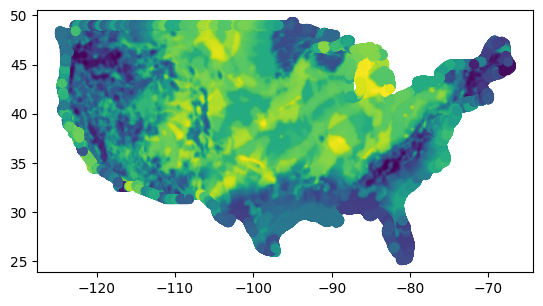

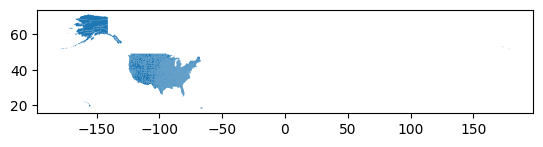

In [25]:

census_df, hydrogen_df = load_data(variables, file_path)


counties_gdf = get_county_boundaries()
if counties_gdf is None:
    print("Cannot proceed without county boundaries!")
    
# Step 3: Create hydrogen points

counties_gdf = counties_gdf.to_crs('EPSG:4326')

hydrogen_gdf = create_hydrogen_points(hydrogen_df)
hydrogen_gdf = hydrogen_gdf.to_crs('EPSG:4326')
hydrogen_gdf.plot(column='hydrogen_prospectivity')
counties_gdf = counties_gdf
counties_gdf.plot()
hydrogen_gdf = hydrogen_gdf.to_crs('EPSG:4326')
print("PRINTING DATA SAMPLES")
print(counties_gdf['geometry'].head())
print(hydrogen_gdf['geometry'].head())

hydrogen_with_counties = gpd.sjoin(
    hydrogen_gdf,
    counties_gdf[['STATEFP', 'COUNTYFP', 'NAME', 'geometry']],
    how='left',
    predicate='intersects'
)

print(f"Longitude range: {hydrogen_df['Lon'].min()} to {hydrogen_df['Lon'].max()}")
print(f"Latitude range: {hydrogen_df['Lat'].min()} to {hydrogen_df['Lat'].max()}")

matched_points = hydrogen_with_counties['NAME'].notna().sum()
total_points = len(hydrogen_with_counties)

print (f"points matched to counties: {matched_points}")

if matched_points == 0:
    print("!!! No points were matched to counties !!!")


STARTING HYDROGEN-CENSUS CORRELATION ANALYSIS
                      NAME  Estimate!!SEX AND AGE!!Total population state  \
0  Autauga County, Alabama                                    58761    01   
1  Baldwin County, Alabama                                   233420    01   
2  Barbour County, Alabama                                    24877    01   
3     Bibb County, Alabama                                    22251    01   
4   Blount County, Alabama                                    59077    01   

  county County  
0    001    NaN  
1    003    NaN  
2    005    NaN  
3    007    NaN  
4    009    NaN  
Longitude range: -124.74 to -66.52
Latitude range: 25.10 to 49.38
***GETTING COUNTY BOUNDARIES***
successfully loaded3222 counties from: cb_2023_us_county_20m/cb_2023_us_county_20m.shp
county data columns: ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOIDFQ', 'GEOID', 'NAME', 'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry']
Created 2205135 hydrogen points
sample

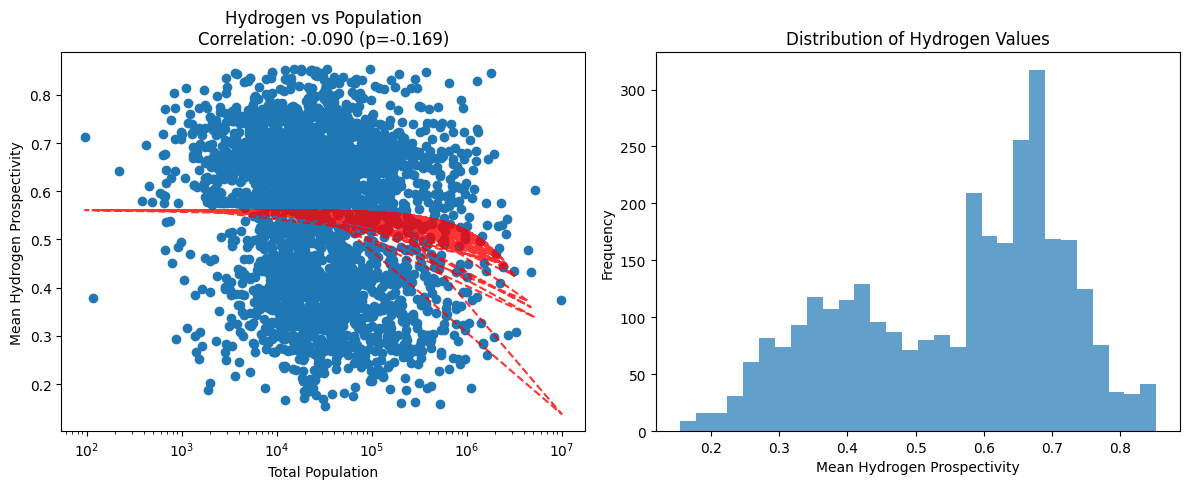

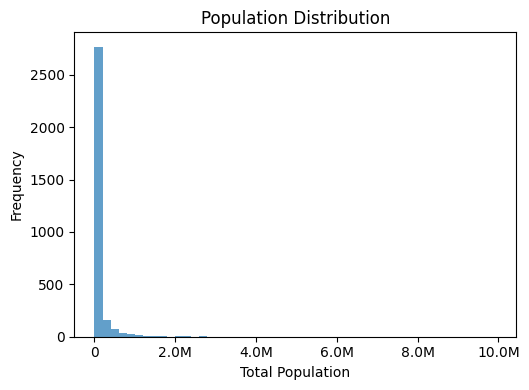

(     state_fips county_fips        NAME  hydrogen_mean  hydrogen_count  \
 0            01         001     Autauga       0.395452             377   
 1            01         003     Baldwin       0.292470            1037   
 2            01         005     Barbour       0.459960             569   
 3            01         007        Bibb       0.520604             393   
 4            01         009      Blount       0.638253             406   
 ...         ...         ...         ...            ...             ...   
 3103         56         037  Sweetwater       0.703443            7350   
 3104         56         039       Teton       0.544015            3098   
 3105         56         041       Uinta       0.661372            1450   
 3106         56         043    Washakie       0.680538            1633   
 3107         56         045      Weston       0.671100            1723   
 
       hydrogen_std  lon_center  lat_center                 county_name  \
 0         0.024408  -8

In [31]:

run_complete_analysis(variables, file_path)